## Introduction ##

Using machine learning and a set of client data from an insurance company, we are to solve the following tasks:
- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

The dataset is provided as follows:

**insurance_us.csv**
- *Gender*: Gender of the insured client.
- *Age*: Client's age.
- *Salary*: Client's salary.
- *Family Members*: Number of family members insured under the client.
- *Insurance Benefits*: Number of benefits claimed by the insured person in the last five years.

## Data Preprocessing & Exploration ##

**Initialization**

In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

**Load and Inspect Data**

In [2]:
# When cloning this project, ensure directory/file paths are correct with respect to user's operating system
df = pd.read_csv('datasets/insurance_us.csv')
display(df.sample(10))
df.info()

,Gender,Age,Salary,Family members,Insurance benefits
3884,0,26.0,48400.0,3,0
3561,1,20.0,45100.0,2,0
183,0,18.0,48300.0,2,0
4231,0,51.0,28300.0,0,2
1594,1,27.0,41600.0,0,0
4836,1,38.0,43600.0,1,0
4080,0,42.0,33700.0,2,0
3738,1,19.0,58300.0,0,0
2660,0,36.0,19900.0,1,0
1703,1,34.0,23500.0,3,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Changing column names and dtypes.

In [3]:
df = df.rename(columns={'Gender': 'gender',
                        'Age': 'age',
                        'Salary': 'income',
                        'Family members': 'family_members',
                        'Insurance benefits': 'insurance_benefits'})
df['age'] = df['age'].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


Checking for missing values, duplicate rows, and overall data integrity.

In [4]:
print(f'Null values:\n{df.isna().sum()}\n')
print(f'Duplicate rows:\n{df.duplicated().sum()}\n')
print(f'Number of unique values:\n{df.nunique()}')
display(df.describe())

Null values:
gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

Duplicate rows:
153

Number of unique values:
gender                  2
age                    46
income                524
family_members          7
insurance_benefits      6
dtype: int64


,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


There are 5,000 entries in the dataset with no missing values. There are 153 identical rows, which is likely a coincidence and not an error for this type of dataset. It accounts for only 3% of the data so we'll drop the duplicate entries. The range of unique values in each column appear to be reasonable, although there is an obvious skew in distribution for the values in *insurance_benefits*.

In [5]:
df = df.drop_duplicates(ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 189.5 KB


## Exploratory Data Analysis ##

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

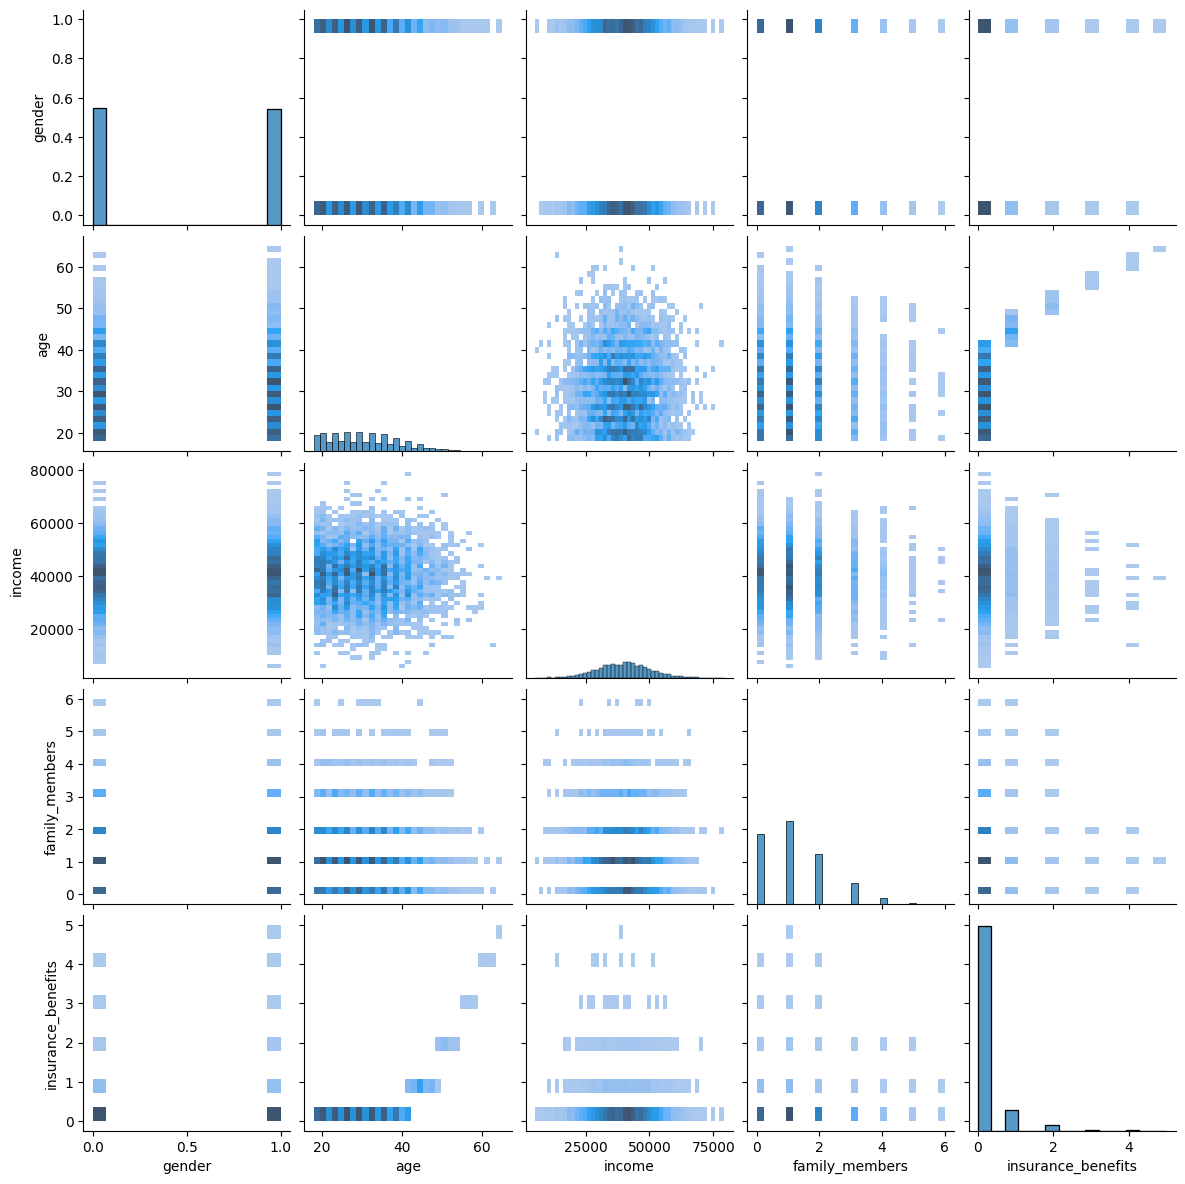

In [6]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

It is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions).

## Task 1. Similar Customers

Find customers who are similar to a given customer. This will help the company's agents with marketing. Test it for four combinations of two cases:
- Scaling
  - the data is not scaled
  - the data is scaled with the MaxAbsScaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

### Function Definitions

We'll define the function <code>get_knn()</code> as follows: 

**Parameters**
- *df*: pandas DataFrame used to find similar objects within
- *n*: object number for which the nearest neighbors are looked for
- *k*: the number of the nearest neighbors to return
- *metric*: name of distance metric (e.g. 'euclidean' or 'manhattan')

**Returns**: DataFarme containing observation n and the k nearest neighbors.

In [7]:
def get_knn(df, n, k, metric):
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df.values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

For scaling the data, we'll define <code>scale_data()</code> as follows:

**Parameters**
- *train_feat*: DataFrame of training features
- *test_feat*: DataFrame of test features, default value of empty Series (single column DataFrame) object

**Returns**: DataFrame of the scaled data, or a tuple of the scaled training and test sets as DataFrame objects.

In [8]:
def scale_data(train_feat, test_feat=pd.Series(dtype=object)):
    feature_names = train_feat.columns
    transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(train_feat.to_numpy())
    
    train_scaled = pd.DataFrame(transformer_mas.transform(train_feat.to_numpy()), columns=feature_names)
    
    if test_feat.empty:
        return train_scaled
    else:
        test_scaled = pd.DataFrame(transformer_mas.transform(test_feat.to_numpy()), columns=feature_names)
        return train_scaled, test_scaled

**Find Similar Records**

We'll find the 10 nearest neighbors (k=10) of observation index 100 (n=100) using different combinations of the following parameters:
- Euclidean vs. Manhattan Distance
- Scaled vs. Original Dataset

In [9]:
features = df.drop('insurance_benefits', axis=1)

display(get_knn(features, 100, 10, 'euclidean'))
display(get_knn(scale_data(features), 100, 10, 'euclidean'))

display(get_knn(features, 100, 10, 'manhattan'))
display(get_knn(scale_data(features), 100, 10, 'manhattan'))

,gender,age,income,family_members,distance
100,0,19,37300.0,1,0.000000
4147,1,19,37300.0,2,1.414214
2569,1,19,37300.0,0,1.414214
1803,0,20,37300.0,2,1.414214
1078,0,22,37300.0,3,3.605551
1780,1,23,37300.0,0,4.242641
3357,1,25,37300.0,0,6.164414
565,1,27,37300.0,0,8.124038
168,0,30,37300.0,0,11.045361
1047,1,30,37300.0,2,11.090537


,gender,age,income,family_members,distance
100,0.0,0.292308,0.472152,0.166667,0.000000
4765,0.0,0.292308,0.477215,0.166667,0.005063
243,0.0,0.292308,0.467089,0.166667,0.005063
1309,0.0,0.292308,0.456962,0.166667,0.015190
806,0.0,0.307692,0.470886,0.166667,0.015437
4694,0.0,0.307692,0.469620,0.166667,0.015592
4387,0.0,0.276923,0.467089,0.166667,0.016196
1628,0.0,0.276923,0.465823,0.166667,0.016636
2991,0.0,0.307692,0.463291,0.166667,0.017754
2736,0.0,0.276923,0.482278,0.166667,0.018418


,gender,age,income,family_members,distance
100,0,19,37300.0,1,0.0
4147,1,19,37300.0,2,2.0
2569,1,19,37300.0,0,2.0
1803,0,20,37300.0,2,2.0
1078,0,22,37300.0,3,5.0
1780,1,23,37300.0,0,6.0
3357,1,25,37300.0,0,8.0
565,1,27,37300.0,0,10.0
168,0,30,37300.0,0,12.0
1047,1,30,37300.0,2,13.0


,gender,age,income,family_members,distance
100,0.0,0.292308,0.472152,0.166667,0.000000
4765,0.0,0.292308,0.477215,0.166667,0.005063
243,0.0,0.292308,0.467089,0.166667,0.005063
1309,0.0,0.292308,0.456962,0.166667,0.015190
806,0.0,0.307692,0.470886,0.166667,0.016650
4694,0.0,0.307692,0.469620,0.166667,0.017916
4387,0.0,0.276923,0.467089,0.166667,0.020448
4490,0.0,0.292308,0.450633,0.166667,0.021519
1628,0.0,0.276923,0.465823,0.166667,0.021714
2991,0.0,0.307692,0.463291,0.166667,0.024245


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Scaling appears to affect the kNN algorithm for our dataset. It is more intuitive to see in the manhattan distance calculation since we're dealing with the sum of the distances for each feature. When the dataset is not scaled, the nearest neighbors that are retrieved are the rows with features that gives us the smallest total distance delta from observation n, but the kNN algorithm does not take into account how representative each feature value is within its individual column. For example, if we have a population with similar income and high dispersion in age, the magnitude of change between observations is relatively small when compared to the alternative case of similarly aged population with a large dispersion in income. When the dataset is scaled or normalized, the feature values should be relative to each other within each column, thus neighbors of n would be more representive of similar observations.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

In our dataset, it appears both distance calculations retrieve similar observations for the most part. The two lists of neighbors begin to differ as the number of neighbors get higher (i.e. k increases).

## Task 2. Is Customer Likely to Receive Insurance Benefit? ##

With *insurance_benefits* being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model. The probability of paying any insurance benefit can be defined as:

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}
$$

The dataset will be split using a 70:30 ratio for training and testing.

**Split the Dataset and Calculate the Target**

In [10]:
df['insurance_benefits_received'] = np.where(df['insurance_benefits'] > 0, 1, 0)

features = df.drop(['insurance_benefits_received', 'insurance_benefits'], axis=1)
target = df['insurance_benefits_received']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.30, random_state=12345)
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train_scaled.shape, X_test_scaled.shape)

(3392, 4) (3392,) (1455, 4) (1455,)
(3392, 4) (1455, 4)


**Check for Class Imbalance**

In [11]:
display(y_train.value_counts())

0    2997
1     395
Name: insurance_benefits_received, dtype: int64

There is a large class imbalance (about 7.5:1), which was expected based on the skewed values found during our examination of the insurance_benefits column.

### Function Definitions

Function, <code>eval_classifier()</code>, defined as follows:  

**Parameters**
- *y_true*: Actual target values
- *y_pred*: Predicted target values

**Returns**: None. Prints the calculated F1 score and confusion matrix.

In [12]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

Function, <code>rnd_model_predict()</code>, defined as follows:  

**Parameters**
- *P*: Probability of insurance benefit received for our constant/dummy cases (e.g. 0, 0.5, 1, etc.)
- *seed*: Pseudo-random seed (default values 42)

**Returns**: Randomly generated binomial that will be used to create our dummy predictions.

In [13]:
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

Evaluating dummy models and recording baseline F1 scores.

In [14]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
            
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



Evaluating the kNN prediction models using the original and scaled datasets.

**Original Dataset**

In [15]:
for n in range(1,11):
    print(f'K = {n}')
    kn_clf = KNeighborsClassifier(n_neighbors=n) 
    kn_clf.fit(X_train, y_train)
    eval_classifier(y_test, kn_clf.predict(X_test))
    print()

K = 1
F1: 0.67
Confusion Matrix
[[0.86323024 0.02130584]
 [0.04604811 0.06941581]]

K = 2
F1: 0.38
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.08728522 0.02817869]]

K = 3
F1: 0.38
Confusion Matrix
[[0.87079038 0.0137457 ]
 [0.08522337 0.03024055]]

K = 4
F1: 0.18
Confusion Matrix
[[0.8790378  0.00549828]
 [0.10378007 0.01168385]]

K = 5
F1: 0.23
Confusion Matrix
[[0.87766323 0.00687285]
 [0.09965636 0.01580756]]

K = 6
F1: 0.06
Confusion Matrix
[[8.83848797e-01 6.87285223e-04]
 [1.12027491e-01 3.43642612e-03]]

K = 7
F1: 0.07
Confusion Matrix
[[0.88316151 0.00137457]
 [0.11134021 0.00412371]]

K = 8
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]

K = 9
F1: 0.01
Confusion Matrix
[[8.84536082e-01 0.00000000e+00]
 [1.14776632e-01 6.87285223e-04]]

K = 10
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]



For the orginal dataset, F1 score decreases as k increases. This is likely due to the class imbalance we observed earlier; the model appears susceptible to misclassification as we look for more neighbors of *n* since the sample subspaces are not uniformly distributed. Specifically, when looking for more than 3 nearest neighbors the model performs worse than our baseline constant model.

**Scaled Dataset**

In [16]:
for n in range(1,11):
    print(f'K = {n}')
    kn_clf = KNeighborsClassifier(n_neighbors=n)      
    kn_clf.fit(X_train_scaled, y_train)
    eval_classifier(y_test, kn_clf.predict(X_test_scaled))
    print()

K = 1
F1: 0.92
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01237113 0.10309278]]

K = 2
F1: 0.89
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02199313 0.09347079]]

K = 3
F1: 0.90
Confusion Matrix
[[0.88041237 0.00412371]
 [0.01786942 0.0975945 ]]

K = 4
F1: 0.87
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02474227 0.09072165]]

K = 5
F1: 0.90
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01786942 0.0975945 ]]

K = 6
F1: 0.85
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02749141 0.08797251]]

K = 7
F1: 0.89
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02061856 0.09484536]]

K = 8
F1: 0.86
Confusion Matrix
[[0.88247423 0.00206186]
 [0.02680412 0.08865979]]

K = 9
F1: 0.87
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02405498 0.09140893]]

K = 10
F1: 0.85
Confusion Matrix
[[0.88178694 0.00274914]
 [0.02749141 0.08797251]]



When the model is trained with the scaled datasets, we can see the F1 score is consistently higher than the dummy models for all k-iterations.

## Task 3. Regression (with Linear Regression) ##

With *insurance_benefits* as the target, evaluate what RMSE would be for a Linear Regression model. Check RMSE for both the original data and the scaled one.

Let's denote:
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as:

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

The analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values:

$$
\hat{y} = X_{val}w
$$

Again, the dataset will be split using a 70:30 ratio. The RMSE metric will be used for the model evaluation. Can you see any difference in RMSE between these two cases?

**Class Definition**

In [17]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        
    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

**Evaluation Function**

Function, <code>eval_regressor()</code>, defined as follows:  

**Parameters**
- *y_true*: Actual target values
- *y_pred*: Predicted target values

**Returns**: None. Prints the calculated RMSE and $R^{2}$ scores.

In [18]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')

**Original Dataset**

In [19]:
X = df[['age', 'gender', 'income', 'family_members']]
y = df['insurance_benefits']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


**Scaled Dataset**

In [20]:
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

lr = MyLinearRegression()
lr.fit(X_train_scaled, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred)

[-0.97736673  2.32727489  0.01955949  0.04378315 -0.07297105]
RMSE: 0.36
R2: 0.66


Even though the feature weights are different, the RMSE and $R^{2}$ scores appear to be the same regardless on which dataset was used to train the model.

## Task 4. Obfuscating Data ##

Data obfuscation will be accomplished by multiplying the numerical features by an invertible matrix $P$:

$$
X' = X \times P
$$

In [21]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

Generating a random matrix $P$.

In [22]:
X = df_pn.to_numpy()
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [23]:
try:
    print(f'Inverse of P:\n{np.linalg.inv(P)}')
except:
    print('Matrix P is not invertible.')

Inverse of P:
[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


**Can you guess the customers' ages or income after the transformation?**

In [24]:
X_prime = X.dot(P)
print(f'Original matrix X\n{X}')
print()
print(f'Transformed matrix X\'\n{X_prime}')

Original matrix X
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Transformed matrix X'
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


The following are samples from the original dataset with the corresponding rows in the transformed matrix.

In [25]:
df_sample = df.sample(5, random_state=12345)
display(df_sample)
display(pd.DataFrame(X_prime[df_sample.index], columns=personal_info_column_list))

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
1321,1,23,47200.0,0,0,0
3767,1,32,65900.0,0,0,0
166,1,33,33900.0,2,0,0
2935,0,39,19300.0,2,0,0
423,0,46,27500.0,2,1,1


,gender,age,income,family_members
0,6049.903497,21281.094461,17520.031555,43762.084321
1,8446.476024,29712.092101,24460.804865,61099.664191
2,4348.221686,15302.363234,12596.916058,31444.425090
3,2477.553757,8732.143396,7186.973144,17917.675270
4,3528.744787,12432.137444,10232.844921,25522.650629


Guessing the original values of X appears to be virtually impossible.

**Can you recover the original data from $X'$ if you know $P$?**

Using the associative property and the multiplicative identity property of matrix multiplication, we can obtain the original matrix X by performing the following operations.  

$\quad X' = X \times P$  
$\quad X' \times P^{-1} = (X \times P) \times P^{-1}$  
$\quad X' \times P^{-1} = X \times (P \times P^{-1})$  
$\quad X' \times P^{-1} = X \times I$  
$\quad X' \times P^{-1} = X$

In [26]:
X_recovered = X_prime.dot(np.linalg.inv(P))

**Print all three cases for a few customers**
- The original data
- The transformed one
- The reversed (recovered) one

In [27]:
print(f'Original matrix X\n{X}')
print()
print(f'Transformed matrix X\'\n{X_prime}')
print()
print(f'Recovered matrix\n{X_recovered}')

Original matrix X
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Transformed matrix X'
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Recovered matrix
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.2700000

Using the previous samples from the original dataset, we'll find the corresponding entries in the recovered matrix.

In [28]:
display(df_sample)
display(pd.DataFrame(X_recovered[df_sample.index], columns=personal_info_column_list))

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
1321,1,23,47200.0,0,0,0
3767,1,32,65900.0,0,0,0
166,1,33,33900.0,2,0,0
2935,0,39,19300.0,2,0,0
423,0,46,27500.0,2,1,1


,gender,age,income,family_members
0,1.000000e+00,23.0,47200.0,-7.427727e-13
1,1.000000e+00,32.0,65900.0,3.019925e-12
2,1.000000e+00,33.0,33900.0,2.000000e+00
3,-2.608625e-12,39.0,19300.0,2.000000e+00
4,-1.949398e-12,46.0,27500.0,2.000000e+00


**You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?**

During the matrix transformations, the values are converted to floating point numbers. The recovered values may not be exactly the same as the original due to rounding errors, specifically for features with a value of zero.

## Proof: Data Obfuscation Can Work with Linear Regression

The data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as:

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

**How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above?**

Based on the proof below, we can see that the formula is linked by the inverse matrix $P^{-1}$:
  
$$w_P = P^{-1} \cdot w $$

**What would be predicted values with $w_P$?**

The predicted values with $w_P$ would be the same as the predicted values before the transformation. We can write the formula to calculate the predicted values with $w_P$ as: 
$$\hat{y_P} = X_{val}P \cdot w_P$$
After we substitute $w_P$, the multipicative identity property gives us the original formula for the predicted values using the original weights $w$.
$$\hat{y_P} = X_{val}P \cdot P^{-1} \cdot w $$
$$\hat{y_P} = X_{val} \cdot I \cdot w $$
$$\hat{y_P} = X_{val} w $$
$$\hat{y_P} = \hat{y} $$


**What does that mean for the quality of linear regression if you measure it with RMSE?**

Since the two are equivalent, we can deduce that the RMSE will be the same (i.e. unaffected by the data obfuscation).



**Analytical proof**

$\quad w_P = [(XP)^T XP]^{-1} (XP)^T y$  
$\quad w_P = [P^T X^T XP]^{-1} P^T X^T y \quad$ Reversity of the transpose of a product of matrices  
$\quad w_P = [P^T (X^TX) P]^{-1} P^T X^T y \quad$ Associative property of multiplication   
$\quad w_P = P^{-1} (X^TX)^{-1} (P^T)^{-1} P^T X^T y \quad$ Multiplicative identity property  
$\quad w_P = P^{-1} (X^TX)^{-1} [(P^T)^{-1} P^T] X^T y \quad$ Associative property of multiplication  
$\quad w_P = P^{-1} (X^TX)^{-1} I \cdot X^T y \quad$ Multiplicative identity property  
$\quad w_P = P^{-1} (X^TX)^{-1} X^T y$  
$\quad w_P = P^{-1} \cdot w $

## Test Linear Regression With Data Obfuscation ##

We can apply our proof using the previously defined functions and values.
- P: invertible matrix of random numbers
- X_prime: features matrix after data obfuscation (i.e. matrix transformation XP)

In [29]:
y = df['insurance_benefits'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_prime, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.97736674 -0.05723409 -0.01932331  0.10398897 -0.02430271]
RMSE: 0.36
R2: 0.66


As suggested by the proof, the RMSE and $R^{2}$ values are the same. Of note, we can see the feature weights reflect the changes to the dataset via transformation.

## Conclusions ##

In this project we see how linear algebra is foundational to machine learning models. Specifically, we learned how linear algebra was used to calculate the nearest neighbors of a given observation as well as feature weight calculations for linear regression models. Understanding how these calculations were made provided insight to the impacts of non-standardized data.

In the case of class imbalances, we saw the quality of the KNearestNeighbor model dramatically decreased as we tried to find more neighbors for a given observation. That is, as k increased, the model was more susceptible to misclassify observations due to the nature of the uneven distribution of sample spaces. Additionally, we were able to improve the model quality after normalizing the dataset via scaling.

During our analysis of matrix transformations, we proved and tested that data obfuscation can work with linear regression models without affecting certain evaluation metrics. While it is nearly impossible to guess the original values, it is important to note that the data can be reverse engineered if the transformation matrix (i.e. matrix P from our examples) is known.